In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

Populating the interactive namespace from numpy and matplotlib


### Чтение данных

In [2]:
year = []
month = []
day = []
group = []
area = []
long = []
lat = []

with open('rgofull.txt') as data_file:
    for line in data_file:
        tmp = line[12:20]
        tmp = ''.join(tmp.split())
        if tmp != '':
            year.append(int(line[:4]))
            month.append(int(line[4:6]))
            day.append(int(line[6:8]))
            group.append(int(line[12:20]))
            area.append(float(line[40:44]))
            long.append(float(line[57:62]))
            lat.append(float(line[63:68]))
            
year = np.array(year)
month = np.array(month)
day = np.array(day)
group = np.array(group)
area = np.array(area)
long = np.array(long)
lat = np.array(lat)

In [3]:
dates = []
inds_p = year >= 1900
year_p = year[inds_p]
month_p = month[inds_p]
day_p = day[inds_p]
for i in range(year_p.shape[0]):
    dates.append(str(year_p[i]) + '-' + str(month_p[i]) + '-' + str(day_p[i]))
c = SkyCoord(long[inds_p]*u.deg, lat[inds_p]*u.deg, obstime=dates, frame=frames.HeliographicCarrington)

In [8]:
year.shape

(161283,)

In [6]:
year_p.shape

(133906,)

In [7]:
from time import time

tic = time()
c1 = c.transform_to(frames.HeliographicStonyhurst)
tac = time()
print(tac - tic)
c1

574.245845079422


<SkyCoord (HeliographicStonyhurst: obstime=['1900-01-01 00:00:00.000' '1900-01-02 00:00:00.000'
 '1900-01-12 00:00:00.000' ... '1975-12-25 00:00:00.000'
 '1975-12-25 00:00:00.000' '1975-12-26 00:00:00.000']): (lon, lat, radius) in (deg, deg, km)
    [( 57.7674468 ,  -8.9, 695508.), ( 70.43708166,  -9. , 695508.),
     (-65.97554853,   9.5, 695508.), ..., ( 31.68076109, -10.4, 695508.),
     (-67.21923891,  -3.9, 695508.), (-54.04694327,  -3.8, 695508.)]>

In [22]:
c1[0].lon.value

57.767446799146626

In [23]:
long1 = c1.lon.value
lat1 = c1.lat.value

In [24]:
with open('longlat.txt', 'w') as out:
    for i in range(long1.shape[0]):
        out.write(str(long1[i]) + ' ' + str(lat1[i]) + '\n')

### Преобразование данных к векторам последовательных площадей для каждой группы

In [25]:
def data_to_area_vectors(year, month, day, group, area):
    g_id = np.unique(group)
    area_vecs = [np.array([])] * g_id.shape[0]
    for i in range(g_id.shape[0]):
        ind = group == g_id[i]
        area_vecs[i] = area[ind]
    return g_id, area_vecs

In [26]:
g_id, area_vecs = data_to_area_vectors(year, month, day, group, area)

In [27]:
g_id.shape

(29761,)

In [28]:
area_vecs = np.array(area_vecs)

### Разделение векторов площадей

In [29]:
sizes = np.array(list(map(lambda v: v.shape[0], area_vecs)))

g_id_3 = g_id[sizes == 3]  # группы с тремя наблюдениями (только для прогнозирования)
g_id_pred = g_id[sizes >= 3]
g_id = g_id[sizes > 3]  # группы с четыремя и больше наблюдениями (для обучения и тестирования)

area_vecs_3 = area_vecs[sizes == 3]
area_vecs_pred = area_vecs[sizes >= 3]
area_vecs = area_vecs[sizes > 3]

# группы с двумя наблюдениями отбрасываются, так как прогнозы будут строиться по трём последовательным площадям

In [30]:
g_id.shape

(15921,)

In [31]:
g_id_3.shape

(2490,)

### Преобразование векторов для обучения к виду обучающей выборки

In [32]:
def area_vecs_to_X_y(g_id, area_vecs):
    '''
    Преобразует векторы площадей area_vecs в обучающую выборку X, y
    X - тройки последовательных площадей
    y - следующее значение площади для каждой тройки из X
    g_id_X - номера групп, соответствующие каждой тройке из X
    '''
    X = []
    y = []
    g_id_X = []
    for i in range(g_id.shape[0]):
        areas = area_vecs[i]
        g = g_id[i]
        for j in range(areas.shape[0] - 3):
            X.append(areas[j:j + 3])
            y.append(areas[j + 3])
            g_id_X.append(g)
    return np.array(X), np.array(y), np.array(g_id_X)

In [33]:
X, y, g_id_X = area_vecs_to_X_y(g_id, area_vecs)

In [34]:
X.shape

(91269, 3)

### Разделение выборки на обучающую и тестовую

In [35]:
def to_train_test(X, y, g_id_X, t=0.25):
    threshold = round(X.shape[0] * (1 - t))
    ind = np.random.choice(X.shape[0], threshold, replace=False)
    ind1 = np.delete(np.arange(X.shape[0]), ind)
    return X[ind], y[ind], g_id_X[ind], X[ind1], y[ind1], g_id_X[ind1]

In [36]:
np.random.seed(42)

X_train, y_train, g_train, X_test, y_test, g_test = to_train_test(X, y, g_id_X)
X_train.shape[0]

68452

### Эксперимент 1: Линейная регрессия с $l_2$ регуляризацией

In [37]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time

pipe = Pipeline([('scale', MinMaxScaler()), ('reg', Ridge(random_state=42))])

params = {'reg__alpha' : np.logspace(-6, -3, 20)}

tic = time()
best_reg = GridSearchCV(pipe, params, cv=3)
best_reg.fit(X_train, y_train)
tac = time()
print('Время работы GridSearch:', tac - tic)

Время работы GridSearch: 0.7590434551239014


In [38]:
best_reg.best_params_

{'reg__alpha': 0.001}

In [39]:
ridge_best_alpha = 0.001

In [40]:
print('R^2 обученной модели на тестовой выборке:', best_reg.score(X_test, y_test))

R^2 обученной модели на тестовой выборке: 0.9109943194285599


### Эксперимент 2: Градиентный бустинг

In [42]:
from catboost import CatBoostRegressor

scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

tic = time()
cb = CatBoostRegressor(n_estimators=10000, custom_metric='R2', eval_metric='R2', random_state=42, verbose=False)
cb.fit(scaled_X_train, y_train, eval_set=(scaled_X_test, y_test), plot=True)
tac = time()
print('Время обучения и лучшая итерация:', tac - tic, cb.tree_count_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Время обучения и лучшая итерация: 163.09332823753357 163


In [47]:
lrs = [0.01, 0.03, 0.1, 0.3, 0.5]
r2 = []
for lr in lrs:
    tic = time()
    cb = CatBoostRegressor(n_estimators=5000, learning_rate=lr, custom_metric='R2', eval_metric='R2', random_state=42, verbose=False)
    cb.fit(scaled_X_train, y_train, eval_set=(scaled_X_test, y_test))
    tac = time()
    print(lr)
    print('Время обучения и лучшая итерация:', tac - tic, cb.tree_count_)
    print(cb.best_score_)
    r2.append(cb.best_score_)
    print('------------------------------------------------------------')

0.01
Время обучения и лучшая итерация: 53.6280677318573 514
{'learn': {'R2': 0.9051770066392195, 'RMSE': 102.27488074451682}, 'validation_0': {'R2': 0.8886771178132573, 'RMSE': 107.38321180419605}}
------------------------------------------------------------
0.03
Время обучения и лучшая итерация: 53.214043617248535 163
{'learn': {'R2': 0.9072443278537319, 'RMSE': 101.1538502873117}, 'validation_0': {'R2': 0.8886690150751118, 'RMSE': 107.38700759162568}}
------------------------------------------------------------
0.1
Время обучения и лучшая итерация: 53.15404033660889 56
{'learn': {'R2': 0.9097568489281523, 'RMSE': 99.77443147302566}, 'validation_0': {'R2': 0.8888051914435654, 'RMSE': 107.32203157890089}}
------------------------------------------------------------
0.3
Время обучения и лучшая итерация: 54.42811298370361 15
{'learn': {'R2': 0.9125646930737766, 'RMSE': 98.2099657595847}, 'validation_0': {'R2': 0.8872783970317413, 'RMSE': 108.05587333766603}}
-----------------------------

best lr : 0.1

In [48]:
mds = [3, 4, 5, 6, 7]
r2_1 = []
for md in mds:
    tic = time()
    cb = CatBoostRegressor(n_estimators=5000, learning_rate=0.1, max_depth=md, custom_metric='R2', eval_metric='R2', random_state=42, verbose=False)
    cb.fit(scaled_X_train, y_train, eval_set=(scaled_X_test, y_test))
    tac = time()
    print(md)
    print('Время обучения и лучшая итерация:', tac - tic, cb.tree_count_)
    print(cb.best_score_)
    r2_1.append(cb.best_score_)
    print('------------------------------------------------------------')

3
Время обучения и лучшая итерация: 33.81393384933472 116
{'learn': {'R2': 0.9049468177534186, 'RMSE': 102.39892219689604}, 'validation_0': {'R2': 0.8864418930741443, 'RMSE': 108.4579243871208}}
------------------------------------------------------------
4
Время обучения и лучшая итерация: 39.82727813720703 55
{'learn': {'R2': 0.9067977029903105, 'RMSE': 101.39708209481884}, 'validation_0': {'R2': 0.8873409660087591, 'RMSE': 108.02640091861232}}
------------------------------------------------------------
5
Время обучения и лучшая итерация: 45.647610902786255 50
{'learn': {'R2': 0.9083830204996882, 'RMSE': 100.53102030680347}, 'validation_0': {'R2': 0.888040735741541, 'RMSE': 107.6898214354257}}
------------------------------------------------------------
6
Время обучения и лучшая итерация: 53.32704997062683 56
{'learn': {'R2': 0.9097568489281523, 'RMSE': 99.77443147302566}, 'validation_0': {'R2': 0.8888051914435654, 'RMSE': 107.32203157890089}}
---------------------------------------

best md : 7

In [51]:
lambs = np.linspace(8, 20, 20)
r2_2 = []
for lamb in lambs:
    tic = time()
    cb = CatBoostRegressor(n_estimators=5000, learning_rate=0.1, max_depth=7, l2_leaf_reg=lamb, custom_metric='R2', eval_metric='R2', random_state=42, verbose=False)
    cb.fit(scaled_X_train, y_train, eval_set=(scaled_X_test, y_test))
    tac = time()
    print(lamb)
    print('Время обучения и лучшая итерация:', tac - tic, cb.tree_count_)
    print(cb.best_score_)
    r2_2.append(cb.best_score_)
    print('------------------------------------------------------------')

8.0
Время обучения и лучшая итерация: 58.99937462806702 56
{'learn': {'R2': 0.9102580361458666, 'RMSE': 99.49697833556819}, 'validation_0': {'R2': 0.8902376422352133, 'RMSE': 106.62852757990576}}
------------------------------------------------------------
8.631578947368421
Время обучения и лучшая итерация: 58.94537162780762 56
{'learn': {'R2': 0.9101771079720997, 'RMSE': 99.54181684556849}, 'validation_0': {'R2': 0.8903897702225578, 'RMSE': 106.5546269348642}}
------------------------------------------------------------
9.263157894736842
Время обучения и лучшая итерация: 62.29756307601929 56
{'learn': {'R2': 0.910137465725609, 'RMSE': 99.56378658245484}, 'validation_0': {'R2': 0.890525823815486, 'RMSE': 106.48848072754775}}
------------------------------------------------------------
9.894736842105264
Время обучения и лучшая итерация: 64.73570275306702 65
{'learn': {'R2': 0.9100696203288292, 'RMSE': 99.60136435780892}, 'validation_0': {'R2': 0.8903766192220871, 'RMSE': 106.56157513804

best lamb : 10.526315789473685

In [55]:
tic = time()
cb = CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, l2_leaf_reg=10.526315789473685, custom_metric='R2', eval_metric='R2', random_state=42, verbose=False)
cb.fit(scaled_X_train, y_train, eval_set=(scaled_X_test, y_test))
tac = time()
print('Время обучения и лучшая итерация:', tac - tic, cb.tree_count_)
print('R^2 на тестовой выборке:', cb.best_score_['validation_0']['R2'])

Время обучения и лучшая итерация: 1.2430710792541504 65
R^2 на тестовой выборке: 0.8907957711141319


Градиентный бустинг показал результат хуже, чем линейная регрессия.

### Эксперимент 3: KNN регрессия с усреднением по таргетам

In [41]:
from sklearn.neighbors import KNeighborsRegressor

params = {'n_neighbors' : np.arange(5, 16)}

tic = time()
best_knn = GridSearchCV(KNeighborsRegressor(), params, cv=3)
best_knn.fit(X_train, y_train)
tac = time()
print('Время работы GridSearch:', tac - tic)

Время работы GridSearch: 16.898966789245605


In [42]:
best_knn.best_params_

{'n_neighbors': 15}

In [43]:
best_knn_k = 15

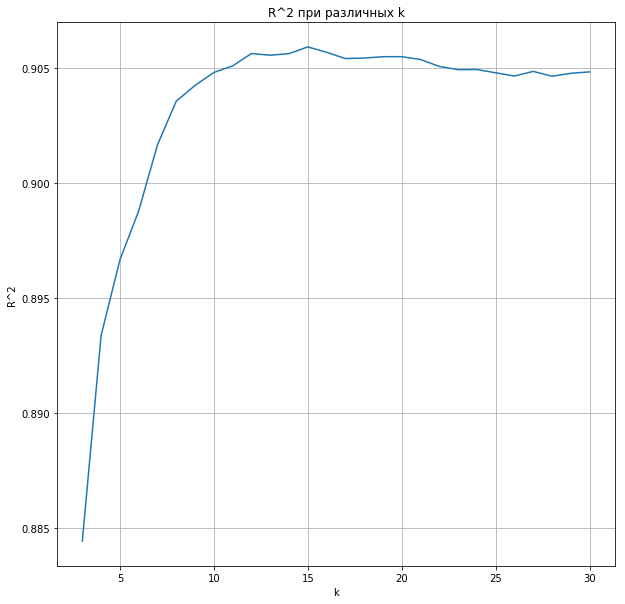

In [56]:
n_neigh = np.arange(3, 31)
r2 = []
plt.figure(figsize=(10, 10))
for k in n_neigh:
    r2.append(KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train).score(X_test, y_test))
plt.plot(n_neigh, r2)
plt.title('R^2 при различных k')
plt.xlabel('k')
plt.ylabel('R^2')
plt.grid()
plt.show()

In [54]:
print('R^2 обученной модели на тестовой выборке:', best_knn.score(X_test, y_test))

R^2 обученной модели на тестовой выборке: 0.9059019355701448


### Эксперимент 4: KNN регрессия с взвешиванием таргетов softmax вероятностями

In [44]:
import scipy.special

def dists_to_softmax(dists):
    return scipy.special.softmax(-dists / np.amax(dists))

In [46]:
params = {'n_neighbors' : np.arange(5, 16)}

tic = time()
best_knn_s = GridSearchCV(KNeighborsRegressor(weights=dists_to_softmax), params, cv=3)
best_knn_s.fit(X_train, y_train)
tac = time()
print('Время работы GridSearch:', tac - tic)

Время работы GridSearch: 17.602006912231445


In [47]:
best_knn_s.best_params_

{'n_neighbors': 15}

In [48]:
best_knn_k_s = 15

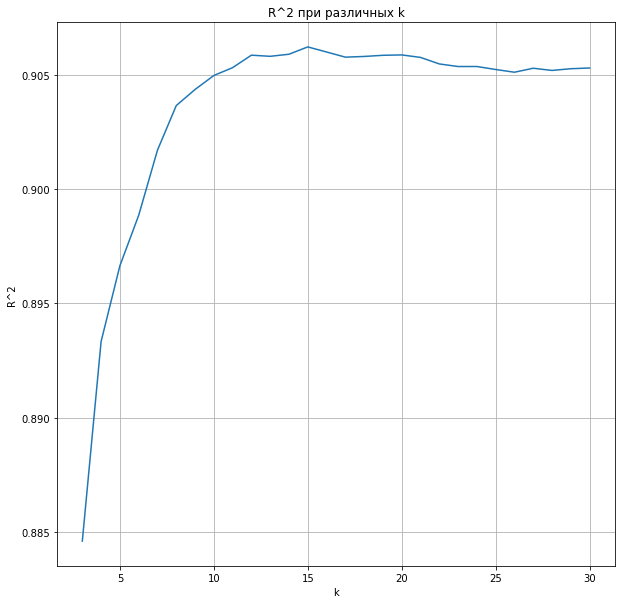

In [98]:
n_neigh = np.arange(3, 31)
r2 = []
plt.figure(figsize=(10, 10))
for k in n_neigh:
    r2.append(KNeighborsRegressor(n_neighbors=k, weights=dists_to_softmax).fit(X_train, y_train).score(X_test, y_test))
plt.plot(n_neigh, r2)
plt.title('R^2 при различных k')
plt.xlabel('k')
plt.ylabel('R^2')
plt.grid()
plt.show()

In [99]:
print('R^2 обученной модели на тестовой выборке:', best_knn_s.score(X_test, y_test))

R^2 обученной модели на тестовой выборке: 0.9062511610975811


### Эксперимент 5: Разное масштабирование расcтояний перед применением softmax

In [109]:
n_neigh = np.arange(8, 31)
r2_1 = []
r2_2 = []
r2_4 = []
r2_8 = []
r2_10 = []
r2_20 = []
r2_30 = []
for k in n_neigh:
    r2_1.append(KNeighborsRegressor(n_neighbors=k, weights=lambda dists: scipy.special.softmax(-dists / np.amax(dists))).fit(X_train, y_train).score(X_test, y_test))
    r2_2.append(KNeighborsRegressor(n_neighbors=k, weights=lambda dists: scipy.special.softmax(-dists / (np.amax(dists) / 2))).fit(X_train, y_train).score(X_test, y_test))
    r2_4.append(KNeighborsRegressor(n_neighbors=k, weights=lambda dists: scipy.special.softmax(-dists / (np.amax(dists) / 4))).fit(X_train, y_train).score(X_test, y_test))
    r2_8.append(KNeighborsRegressor(n_neighbors=k, weights=lambda dists: scipy.special.softmax(-dists / (np.amax(dists) / 8))).fit(X_train, y_train).score(X_test, y_test))
    r2_10.append(KNeighborsRegressor(n_neighbors=k, weights=lambda dists: scipy.special.softmax(-dists / (np.amax(dists) / 10))).fit(X_train, y_train).score(X_test, y_test))
    r2_20.append(KNeighborsRegressor(n_neighbors=k, weights=lambda dists: scipy.special.softmax(-dists / (np.amax(dists) / 20))).fit(X_train, y_train).score(X_test, y_test))
    r2_30.append(KNeighborsRegressor(n_neighbors=k, weights=lambda dists: scipy.special.softmax(-dists / (np.amax(dists) / 30))).fit(X_train, y_train).score(X_test, y_test))

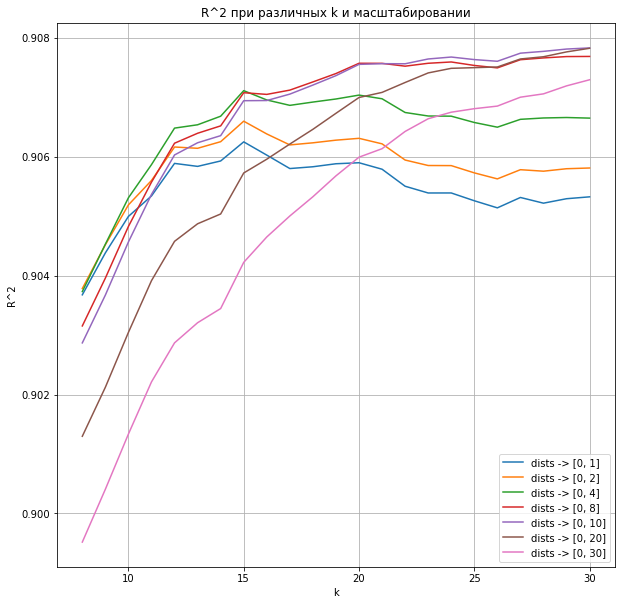

In [110]:
plt.figure(figsize=(10, 10))
plt.plot(n_neigh, r2_1, label='dists -> [0, 1]')
plt.plot(n_neigh, r2_2, label='dists -> [0, 2]')
plt.plot(n_neigh, r2_4, label='dists -> [0, 4]')
plt.plot(n_neigh, r2_8, label='dists -> [0, 8]')
plt.plot(n_neigh, r2_10, label='dists -> [0, 10]')
plt.plot(n_neigh, r2_20, label='dists -> [0, 20]')
plt.plot(n_neigh, r2_30, label='dists -> [0, 30]')
plt.title('R^2 при различных k и масштабировании')
plt.xlabel('k')
plt.ylabel('R^2')
plt.legend()
plt.grid()
plt.show()

In [111]:
print('R^2 лучшего варианта (k = 30, dists -> [0, 10]):', r2_10[-1])

R^2 лучшего варианта (k = 30, dists -> [0, 10]): 0.9078315865769213


#### Итог: лучшее качество показала линейная регрессия с $l_2$ регуляризацией, $R^2 = 0.9109943194285599$ на тестовой выборке.

### Применение моделей

In [49]:
g_id_p, area_vecs_p = data_to_area_vectors(year[inds_p], month[inds_p], day[inds_p], group[inds_p], area[inds_p])
area_vecs_p = np.array(area_vecs_p)

In [50]:
sizes_p = np.array(list(map(lambda v: v.shape[0], area_vecs_p)))

g_id_p = g_id_p[sizes_p >= 3]

area_vecs_p = area_vecs_p[sizes_p >= 3]

In [52]:
inds = []
day_bias = []
for g in g_id_p:
    ind = group[inds_p] == g
    tmp = long1[ind]
    if tmp[0] >= -53 and tmp[0] <= 53:
    # для прогнозирования выбираются только те группы, первое налюдение которых было в диапазоне долгот (-53, 53) солнечного диска
        inds.append(True)
        day_bias.append(round(tmp[0] / 13.2))
    else:
        inds.append(False)

In [53]:
g_id_p = g_id_p[inds]
area_vecs_p = area_vecs_p[inds]

In [54]:
g_id_p.shape

(5645,)

In [70]:
def make_predictions(best_reg, year, month, day, group, area, g_id_p, area_vecs_p, day_bias):
    pred_year = []
    pred_month = []
    pred_day = []
    pred_area = []
    pred_group = []
    pred_vecs = []
    for i in range(g_id_p.shape[0]):
        g = g_id_p[i]
        vec = area_vecs_p[i]
        i1 = np.logical_and(group == g, area == vec[-1])
        y1, m1, d1 = year[i1][0], month[i1][0], day[i1][0]
        check = True
        while check and vec.shape[0] <= 20 - day_bias[i]:
            new_ar = best_reg.predict(np.reshape(vec[-3:], (1, -1)))[0]
            pred_area.append(new_ar)
            pred_group.append(g)
            vec = np.append(vec, new_ar)
            d1 += 1
            if m1 in [1, 3, 5, 7, 8, 10]:
                if d1 > 31:
                    m1 += 1
                    d1 = 1
            elif m1 in [4, 6, 9, 11]:
                if d1 > 30:
                    m1 += 1
                    d1 = 1
            elif m1 == 12:
                if d1 > 31:
                    y1 += 1
                    m1 = 1
                    d1 = 1
            elif m1 == 2:
                if d1 == 29:
                    if not (y1 % 400 == 0 or (y1 % 100 != 0 and y1 % 4 == 0)):
                        d1 = 1
                        m1 += 1
                elif d1 > 29:
                    d1 = 1
                    m1 += 1
            else:
                print('Неверный месяц')
            pred_year.append(y1)
            pred_month.append(m1)
            pred_day.append(d1)
            if new_ar <= 50:
                check = False
        pred_vecs.append(vec)
    return pred_year, pred_month, pred_day, pred_area, pred_group, pred_vecs

### Линейная регрессия

In [71]:
tic = time()
pred_year, pred_month, pred_day, pred_area, pred_group, pred_vecs = make_predictions(best_reg, year, month, day, group, area, g_id_p, area_vecs_p, day_bias)
tac = time()
print(tac - tic)

5.763329744338989


In [86]:
vec_sizes = np.array(list(map(lambda v: v.shape[0], pred_vecs)))

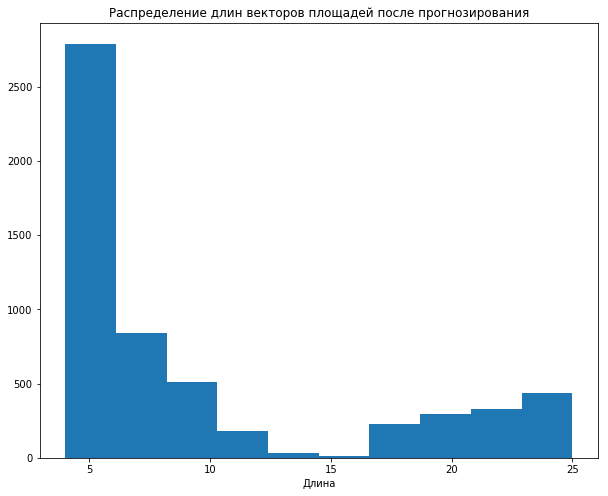

In [90]:
plt.figure(figsize=(10, 8))
plt.hist(vec_sizes)
plt.title('Распределение длин векторов площадей после прогнозирования')
plt.xlabel('Длина')
plt.show()

In [94]:
lr_y = np.append(year[inds_p], pred_year)
lr_m = np.append(month[inds_p], pred_month)
lr_d = np.append(day[inds_p], pred_day)
lr_g = np.append(group[inds_p], pred_group)
lr_a = np.append(area[inds_p], pred_area)
sums = []

tic = time()
tmpy = np.sort(np.unique(lr_y))
for y1 in tmpy:
    tmpm = np.sort(np.unique(lr_m[lr_y == y1]))
    for m1 in tmpm:
        tmpd = np.sort(np.unique(lr_d[np.logical_and(lr_y == y1, lr_m == m1)]))
        for d1 in tmpd:
            tmpi = np.logical_and(np.logical_and(lr_y == y1, lr_m == m1), lr_d == d1)
            sums.append(np.sum(lr_a[tmpi]))
tac = time()
print(tac - tic)

10.756615161895752


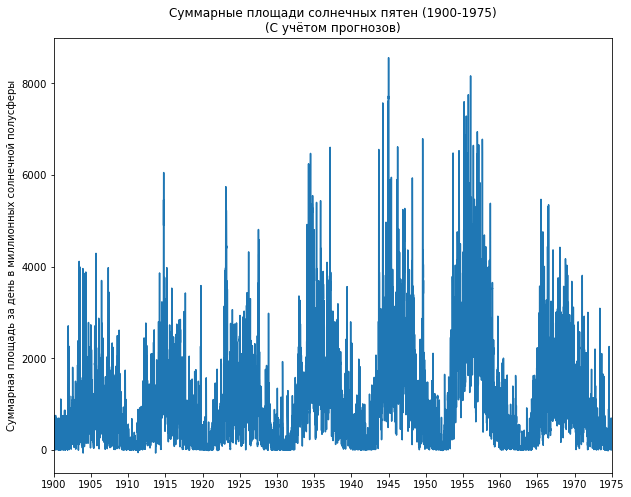

In [117]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(sums)), sums)
plt.title('Суммарные площади солнечных пятен (1900-1975)\n(С учётом прогнозов)')
plt.xticks(np.linspace(0, len(sums), 16), np.arange(1900, 1976, 5))
plt.xlim([0, len(sums)])
plt.ylabel('Суммарная площадь за день в миллионных солнечной полусферы')
plt.show()

In [122]:
mean_sums = []
for i in range(len(sums) - 183):
    mean_sums.append(np.mean(sums[i:i + 183]))

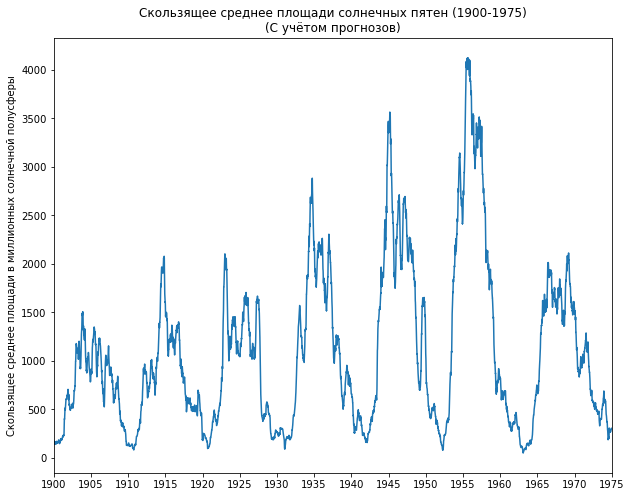

In [123]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(mean_sums)), mean_sums)
plt.title('Скользящее среднее площади солнечных пятен (1900-1975)\n(С учётом прогнозов)')
plt.xticks(np.linspace(0, len(mean_sums), 16), np.arange(1900, 1976, 5))
plt.xlim([0, len(mean_sums)])
plt.ylabel('Скользящее среднее площади в миллионных солнечной полусферы')
plt.show()

### KNN (подобранный лучший вариант)

In [124]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=30, weights=lambda dists: scipy.special.softmax(-dists / (np.amax(dists) / 10))).fit(X_train, y_train)
tic = time()
pred_year, pred_month, pred_day, pred_area, pred_group, pred_vecs = make_predictions(knn_reg, year, month, day, group, area, g_id_p, area_vecs_p, day_bias)
tac = time()
print(tac - tic)

12.81773328781128


In [125]:
vec_sizes = np.array(list(map(lambda v: v.shape[0], pred_vecs)))

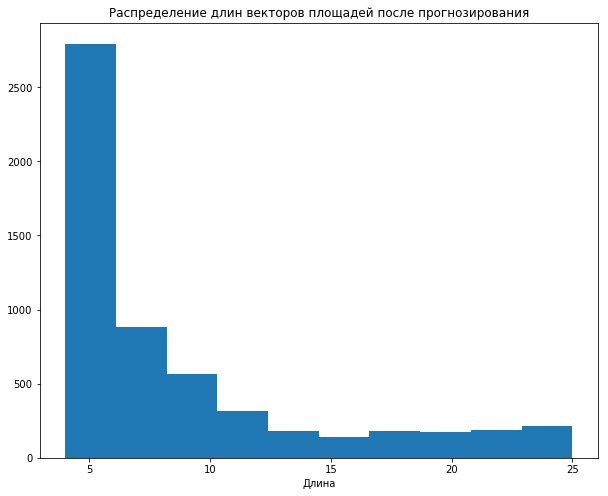

In [126]:
plt.figure(figsize=(10, 8))
plt.hist(vec_sizes)
plt.title('Распределение длин векторов площадей после прогнозирования')
plt.xlabel('Длина')
plt.show()

In [127]:
lr_y = np.append(year[inds_p], pred_year)
lr_m = np.append(month[inds_p], pred_month)
lr_d = np.append(day[inds_p], pred_day)
lr_g = np.append(group[inds_p], pred_group)
lr_a = np.append(area[inds_p], pred_area)
sums = []

tic = time()
tmpy = np.sort(np.unique(lr_y))
for y1 in tmpy:
    tmpm = np.sort(np.unique(lr_m[lr_y == y1]))
    for m1 in tmpm:
        tmpd = np.sort(np.unique(lr_d[np.logical_and(lr_y == y1, lr_m == m1)]))
        for d1 in tmpd:
            tmpi = np.logical_and(np.logical_and(lr_y == y1, lr_m == m1), lr_d == d1)
            sums.append(np.sum(lr_a[tmpi]))
tac = time()
print(tac - tic)

10.575604915618896


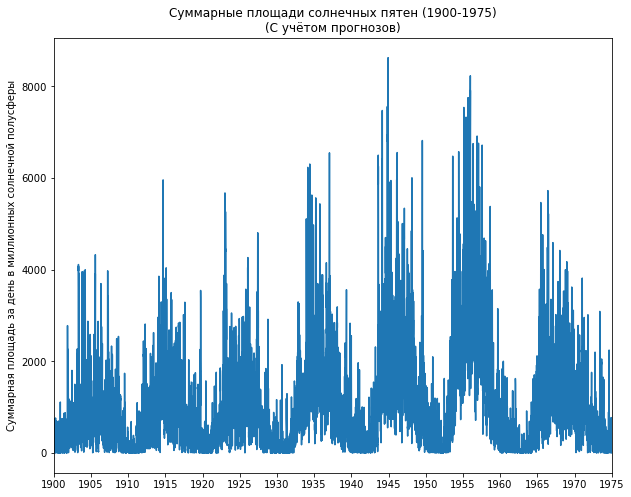

In [128]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(sums)), sums)
plt.title('Суммарные площади солнечных пятен (1900-1975)\n(С учётом прогнозов)')
plt.xticks(np.linspace(0, len(sums), 16), np.arange(1900, 1976, 5))
plt.xlim([0, len(sums)])
plt.ylabel('Суммарная площадь за день в миллионных солнечной полусферы')
plt.show()

In [129]:
mean_sums = []
for i in range(len(sums) - 183):
    mean_sums.append(np.mean(sums[i:i + 183]))

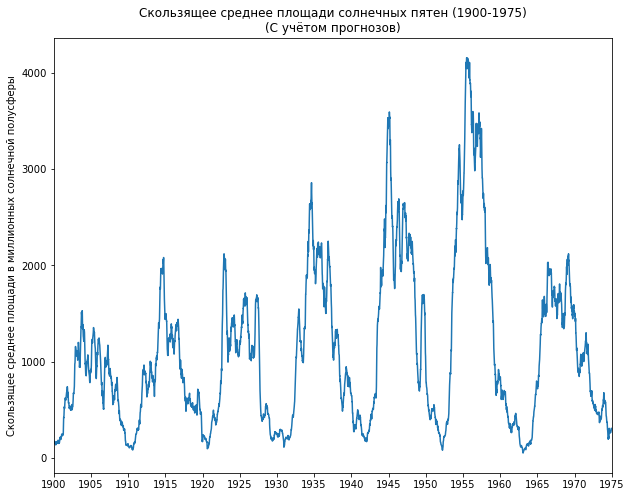

In [130]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(mean_sums)), mean_sums)
plt.title('Скользящее среднее площади солнечных пятен (1900-1975)\n(С учётом прогнозов)')
plt.xticks(np.linspace(0, len(mean_sums), 16), np.arange(1900, 1976, 5))
plt.xlim([0, len(mean_sums)])
plt.ylabel('Скользящее среднее площади в миллионных солнечной полусферы')
plt.show()